In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from qiskit.circuit.library import TwoLocal
from qiskit_nature.drivers import PySCFDriver, Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis
from qiskit_nature.transformers.second_quantization.electronic.active_space_transformer import ActiveSpaceTransformer
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit import Aer
from entanglement_forging import reduce_bitstrings

import sys
sys.path.append('../../')
from entanglement_forging import (EntanglementForgedConfig, EntanglementForgedDriver, EntanglementForgedGroundStateSolver)
from entanglement_forging import Log

In [3]:
molecule = Molecule(geometry = [['C',[-1.662349902448, -0.695322331415, -0.307726967072]],
                                ['C',[0.477506399751, -1.159887599109, 0.386176362728]],
                                ['C',[0.465033028474, 1.178065976344, 0.346006737462]],
                                ['C',[-1.669162693941, 0.665549642529, -0.333932016197]],
                                ['C',[0.353240259603, 0.025254735280, 1.345385392500]],
                                ['H',[1.236672966467, 0.041367363616, 2.008294800099]],
                                ['H',[-0.545529019687, 0.031307436573, 1.971273375160]],
                                ['H',[0.387169841664, -2.199386408363, 0.712397189321]],
                                ['H',[0.365402809281, 2.227055868201, 0.637306711025]],
                                ['H',[-1.573663113993, -1.275918322039, -1.226211748221]],
                                ['H',[-1.583878458115, 1.210474104515, -1.274313037410]],
                                ['H',[-2.033162089723, -1.244377161302, 0.558595832016]],
                                ['H',[-2.046566709656, 1.244731052782, 0.509648077185]],
                                ['C',[1.139953226957, -0.725010259076, -0.736843572958]],
                                ['C',[1.131273764619, 0.711596029626, -0.762213847697]],
                                ['H',[1.502490625700, -1.357451877629, -1.549059430283]],
                                ['H',[1.487075446023, 1.319266551725, -1.596040408218]]],                                   
                    charge       = 0,
                    multiplicity = 1)

driver    = PySCFDriver(molecule=molecule,basis='sto-3g')
converter = QubitConverter(JordanWignerMapper())

In [4]:
#Molecular problem was transformed as the Hamiltonian in the 4 orbital active space. 

transformer= ActiveSpaceTransformer(num_electrons=4, num_molecular_orbitals=4)
problem_reduced = ElectronicStructureProblem(driver, [transformer])
solver = GroundStateEigensolver(converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False))
result = solver.solve(problem_reduced)
print('Classical energy = ', result.total_energies[0])

Classical energy =  (-267.524787205886+0j)


In [5]:
H_fermionic = problem_reduced.second_q_ops()[0]

In [6]:
electronic_energy_object = problem_reduced.grouped_property_transformed.get_property('ElectronicEnergy')
energy_shift = electronic_energy_object._shift['ActiveSpaceTransformer']+electronic_energy_object._nuclear_repulsion_energy


In [7]:
#These are the integrals in the molecular orbital basis retrieved from the 4 orbital active space. 

one_body_integrals_alpha = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 1)._matrices[0]
one_body_integrals_beta = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 1)._matrices[1]

two_body_integrals_alpha_alpha = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 2)._matrices[0]
two_body_integrals_beta_alpha = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 2)._matrices[1]
two_body_integrals_beta_beta = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 2)._matrices[2]
two_body_integrals_alpha_beta = electronic_energy_object.get_electronic_integral(ElectronicBasis.MO, 2)._matrices[3]

In [8]:
#Setting up the entanglement forging problem in the 4 orbital active space:

driver = EntanglementForgedDriver(hcore=one_body_integrals_alpha,
                                  mo_coeff=np.eye(4,4),
                                  eri=two_body_integrals_alpha_alpha,
                                  num_alpha=2,
                                  num_beta=2,
                                  nuclear_repulsion_energy=energy_shift)
problem = ElectronicStructureProblem(driver)
problem.second_q_ops()

converter = QubitConverter(JordanWignerMapper())

In [9]:
orbitals_to_reduce=[]
from entanglement_forging import reduce_bitstrings

#Feature request: ability to input asymmetric bitstrings with the same number of qubits. 

bitstrings_u = [[1, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 1, 1, 0], [1, 0, 0, 1], [1, 1, 0, 0]]
bitstrings_v = [[1, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0], [0, 0, 1, 1]]

In [10]:
from qiskit.circuit import Parameter, QuantumCircuit

brickwall =[(2,3),(1,2),(0,1),(2,3),(1,2),(2,3)]

n_theta    = len(brickwall)
nqubit = len(bitstrings_u[0])
theta    = Parameter('θ')
hop_gate = QuantumCircuit(2, name="Hop gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

theta_vec = [Parameter('θ%d'%i) for i in range(n_theta)]

In [11]:
ansatz = QuantumCircuit(nqubit)
for m,(i,j) in enumerate(brickwall):
    ansatz.append(hop_gate.to_gate({theta:theta_vec[m]}),[i,j])

ansatz.draw('text', justify='right', fold=-1)

┌───────────────┐                                  
q_0: ──────────────────────────────────┤0              ├──────────────────────────────────
                      ┌───────────────┐│  Hop gate(θ2) │┌───────────────┐                 
q_1: ─────────────────┤0              ├┤1              ├┤0              ├─────────────────
     ┌───────────────┐│  Hop gate(θ1) │├───────────────┤│  Hop gate(θ4) │┌───────────────┐
q_2: ┤0              ├┤1              ├┤0              ├┤1              ├┤0              ├
     │  Hop gate(θ0) │└───────────────┘│  Hop gate(θ3) │└───────────────┘│  Hop gate(θ5) │
q_3: ┤1              ├─────────────────┤1              ├─────────────────┤1              ├
     └───────────────┘                 └───────────────┘                 └───────────────┘

In [12]:
from entanglement_forging import Log
Log.VERBOSE = True

In [13]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
config = EntanglementForgedConfig(backend = backend, maxiter = 30, initial_params=[0.1]*n_theta,optimizer_name='L_BFGS_B')

Configuration settings are valid.


In [14]:
#Feature request: ability to input U and V ansatze separately

calc = EntanglementForgedGroundStateSolver(converter, ansatz, bitstrings_u, bitstrings_v, config, orbitals_to_reduce)
res = calc.solve(problem)

{'maxiter': 30}
------ new iteration energy evaluation -----
duration of last iteration: nan
Parameter sets: [[0.1 0.1 0.1 0.1 0.1 0.1]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [0.1 0.1 0.1 0.1 0.1 0.1] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67571665  0.19804041  0.19916254  0.05410208  0.07071957 -0.67571665
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.322894811630249
Parameter sets: [[0.1 0.1 0.1 0.1 0.1 0.1]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set 

Constructing the circuits for parameter set [0.07127505 0.11344727 0.07725772 0.07886502 0.08974042 0.06967141] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67441402  0.20941394  0.19881992  0.05170627  0.06537861 -0.67441402
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.2872090339660645
Parameter sets: [[0.07127505 0.11344727 0.07725772 0.07886502 0.08974042 0.06967141]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [0.07127505 0.11344727 0.07725772 0.07886502 0.08974042 0.06967141] ...
inferred number of pauli groups for tensor state

Constructing the circuits for parameter set [-0.01145801  0.10527524 -0.00254712 -0.00140445  0.10943325 -0.01797982] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67260322  0.22312723  0.19955774  0.04779574  0.05758768 -0.67260322
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.3330111503601074
Parameter sets: [[-0.01145801  0.10527524 -0.00254712 -0.00140445  0.10943325 -0.01797982]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [-0.01145801  0.10527524 -0.00254712 -0.00140445  0.10943325 -0.01797982] ...
inferred number of pauli group

Constructing the circuits for parameter set [ 0.00104951  0.10675919  0.00971906  0.01038921  0.10664233 -0.00480862] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67255999  0.22333712  0.19954837  0.04793678  0.05769901 -0.67255999
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.385880708694458
Parameter sets: [[ 0.00104951  0.10675919  0.00971906  0.01038921  0.10664233 -0.00480862]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.00104951  0.10675919  0.00971906  0.01038921  0.10664233 -0.00480862] ...
inferred number of pauli groups

Constructing the circuits for parameter set [ 0.00260157  0.10844935  0.01024411  0.00641058  0.10829816 -0.0038803 ] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.6725577   0.22333546  0.1995855   0.04791545  0.05764801 -0.6725577
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.3582568168640137
Parameter sets: [[ 0.00260157  0.10844935  0.01024411  0.00641058  0.10829816 -0.0038803 ]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.00260157  0.10844935  0.01024411  0.00641058  0.10829816 -0.0038803 ] ...
inferred number of pauli groups

Constructing the circuits for parameter set [ 0.00450776  0.11531819  0.01417835  0.00366436  0.11519021 -0.0049142 ] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67255803  0.22332973  0.19957757  0.04796985  0.05764475 -0.67255803
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.373983144760132
Parameter sets: [[ 0.00450776  0.11531819  0.01417835  0.00366436  0.11519021 -0.0049142 ]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.00450776  0.11531819  0.01417835  0.00366436  0.11519021 -0.0049142 ] ...
inferred number of pauli groups

Constructing the circuits for parameter set [ 0.01927433  0.17694761  0.02860649  0.00028514  0.1769018  -0.01801686] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67256008  0.22330199  0.19944792  0.04832121  0.05785915 -0.67256008
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.2395260334014893
Parameter sets: [[ 0.01927433  0.17694761  0.02860649  0.00028514  0.1769018  -0.01801686]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.01927433  0.17694761  0.02860649  0.00028514  0.1769018  -0.01801686] ...
inferred number of pauli group

Constructing the circuits for parameter set [ 0.09797931  0.51209944  0.05469658  0.02716827  0.51273357 -0.09447435] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67245388  0.22354669  0.19827454  0.05066645  0.06130706 -0.67245388
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.2428102493286133
Parameter sets: [[ 0.09797931  0.51209944  0.05469658  0.02716827  0.51273357 -0.09447435]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.09797931  0.51209944  0.05469658  0.02716827  0.51273357 -0.09447435] ...
inferred number of pauli group

Constructing the circuits for parameter set [ 0.12328635  0.6196812   0.04003111  0.04468201  0.63194181 -0.12271172] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67241766  0.22380812  0.19786594  0.05055125  0.06255039 -0.67241766
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.372818946838379
Parameter sets: [[ 0.12328635  0.6196812   0.04003111  0.04468201  0.63194181 -0.12271172]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.12328635  0.6196812   0.04003111  0.04468201  0.63194181 -0.12271172] ...
inferred number of pauli groups

Constructing the circuits for parameter set [ 0.10250814  0.53613214  0.03716501  0.03086729  0.53847496 -0.10228609] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67244314  0.22369006  0.19851704  0.04988986  0.0608703  -0.67244314
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.367166042327881
Parameter sets: [[ 0.10250814  0.53613214  0.03716501  0.03086729  0.53847496 -0.10228609]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.10250814  0.53613214  0.03716501  0.03086729  0.53847496 -0.10228609] ...
inferred number of pauli groups

num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.13075518  0.66689297  0.02536551  0.01984664  0.66599979 -0.13464606] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67241387  0.22388514  0.19890803  0.04935025  0.05995633 -0.67241387
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.2440261840820312
Parameter sets: [[ 0.13075518  0.66689297  0.02536551  0.01984664  0.66599979 -0.13464606]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.13075518  0.66689297  0.02536551  0.

num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.18663048  0.90568468  0.02374875  0.0185308   0.90743381 -0.19040665] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67236033  0.2240825   0.19888366  0.04965361  0.0602496  -0.67236033
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.1964452266693115
Parameter sets: [[ 0.18663048  0.90568468  0.02374875  0.0185308   0.90743381 -0.19040665]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.18663048  0.90568468  0.02374875  0.

Constructing the circuits for parameter set [ 0.23149846  1.09406708  0.02058397  0.01606127  1.095945   -0.2327935 ] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67235753  0.22406459  0.19898913  0.04969175  0.05999843 -0.67235753
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.2359280586242676
Parameter sets: [[ 0.23149846  1.09406708  0.02058397  0.01606127  1.095945   -0.2327935 ]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.23149846  1.09406708  0.02058397  0.01606127  1.095945   -0.2327935 ] ...
inferred number of pauli group

Constructing the circuits for parameter set [ 0.23244237  1.09705187  0.0203507   0.01672446  1.09908061 -0.2330292 ] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67235586  0.22406783  0.19898058  0.04968674  0.0600564  -0.67235586
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.372056007385254
Parameter sets: [[ 0.23244237  1.09705187  0.0203507   0.01672446  1.09908061 -0.2330292 ]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.23244237  1.09705187  0.0203507   0.01672446  1.09908061 -0.2330292 ] ...
inferred number of pauli groups

Constructing the circuits for parameter set [ 0.23095795  1.09084343  0.02037858  0.01674799  1.09273767 -0.23051879] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67235657  0.22406032  0.19898613  0.04967985  0.06005583 -0.67235657
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.375108003616333
Parameter sets: [[ 0.23095795  1.09084343  0.02037858  0.01674799  1.09273767 -0.23051879]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.23095795  1.09084343  0.02037858  0.01674799  1.09273767 -0.23051879] ...
inferred number of pauli groups

Constructing the circuits for parameter set [ 0.23703359  1.12935653  0.0206065   0.01661308  1.13126979 -0.23561547] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67235145  0.22406943  0.19898843  0.04977135  0.06005294 -0.67235145
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.535885810852051
Parameter sets: [[ 0.23703359  1.12935653  0.0206065   0.01661308  1.13126979 -0.23561547]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.23703359  1.12935653  0.0206065   0.01661308  1.13126979 -0.23561547] ...
inferred number of pauli groups

Constructing the circuits for parameter set [ 0.22367849  1.09081899  0.02034982  0.01678671  1.09265666 -0.22324261] ...
inferred number of pauli groups for tensor statepreps: 8.0
inferred number of pauli groups for superposition statepreps: 32.0
Transpiling circuits...
None
Building pseudo-richardson circuits...
Executing 72 circuits...
Result of circuit execution: {result}
Done executing. Analyzing results...
Optimal schmidt coeffs sqrt(p) = [-0.67235659  0.22405668  0.19898914  0.04970089  0.06004141 -0.67235659
  0.          0.          0.          0.          0.          0.        ]
------ new iteration energy evaluation -----
duration of last iteration: 3.2581839561462402
Parameter sets: [[ 0.22367849  1.09081899  0.02034982  0.01678671  1.09265666 -0.22324261]]
num paulis for tensor states: 53
num paulis for superpos states: 17
Constructing the circuits for parameter set [ 0.22367849  1.09081899  0.02034982  0.01678671  1.09265666 -0.22324261] ...
inferred number of pauli group

VQE for this problem took 903.5562620162964 seconds


In [15]:
res

Ground state energy (Hartree): (-267.542522599336+0j)
Schmidt values: [-0.6723576   0.2240489   0.198996    0.04971787  0.06001115 -0.6723576
  0.          0.          0.          0.          0.          0.        ]
Optimizer parameters: [ 0.21206341  1.08989625  0.02011886  0.01693577  1.09132429 -0.2122293 ]

Energies (from only one paramset in each iteration):


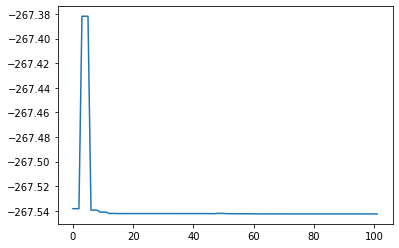

Schmidts (from only one paramset in each iteration):


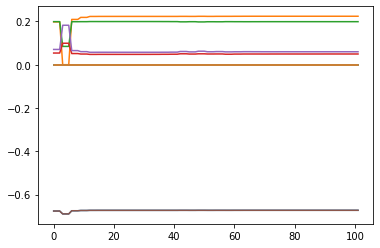

In [16]:
print('Energies (from only one paramset in each iteration):')
plt.plot([e[0] for e in res.get_energies_history()])
plt.show()
print('Schmidts (from only one paramset in each iteration):')
plt.plot([s[0] for s in res.get_schmidts_history()])
plt.show()